In [1]:
import numpy as np
np.__version__

'1.21.4'

In [2]:
from acquisition_function import ACQ1
from acquisition_function import ACQ
from acquisition_function import Thompson,PI, EI


Read Data

In [1]:
cd "C:\Users\lijing\OneDrive\4742\PersonalProject_OurBranch\WM-SecuritySelection"

C:\Users\lijing\OneDrive\4742\PersonalProject_OurBranch\WM-SecuritySelection


In [2]:
from clean_data import ReadData
from train_data import TrainDataLearning
from train_data import TrainDataLearningBatch
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from utils import read_json, write_json


if __name__=="__main__": 
    filepath_1 = "C:/Users/lijing/OneDrive/4742/PersonalProject_OurBranch/WM-SecuritySelection/security_selection/automation/notebooks/MF_LargeCap_ExcessReturn_3Y.parquet"
    Data=ReadData(filepath_1)
    data_dict, label_dict=Data.prepare_data_for_er_ari()
    x_train, x_val, y_train, y_val=Data.train_test_data(data_dict,label_dict)


Bad key "text.kerning_factor" on line 4 in
C:\Users\lijing\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
100%|██████████| 1130/1130 [00:12<00:00, 90.94it/s] 


In [4]:
lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')

In [6]:
import os
import json
import warnings
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from sklearn.gaussian_process.kernels import Matern
from GPy.mappings.constant import Constant
from GPy.kern import Matern52
from GPy.models import GPRegression

from scipy.special import ndtr
from scipy.stats import norm

warnings.filterwarnings('ignore')
# plt.style.use('classic')
plt.style.use('seaborn-paper')
%matplotlib inline

In [7]:
# plotting styles

def nnsvm(rcParams, i=0):
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = 'Ubuntu'
    rcParams['font.monospace'] = 'Ubuntu Mono'
    rcParams['font.size'] = 12 + i
    rcParams['axes.labelsize'] = 12 + i
    rcParams['axes.labelweight'] = 'normal'
    rcParams['xtick.labelsize'] = 10 + i
    rcParams['ytick.labelsize'] = 10 + i
    rcParams['legend.fontsize'] = 12 + i
    rcParams['figure.titlesize'] = 14 + i
    rcParams['lines.linewidth']= 2.7
    rcParams['axes.titlesize'] = 14 + i
alpha_plt = 0.3 # beautification
    
# gifs stuff
gifDir = 'MAB_gifs'
os.makedirs(gifDir, exist_ok=True)
delay = 80

SPINE_COLOR = 'gray'

def format_axes(ax):
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
        
    ax.grid(alpha=.25)

    return ax

#### Explore the relationship between the inverse of RMSE and learning rate

Active learning: predict distribution by reducing uncertainty. One of the ways we can reduce the uncertainty is by choosing the point at which we have the maximum variance (we are most uncertain). We use Gaussian Processes to get a prediction as well as the attached uncertainty (variance) with that prediction. This will turn out to be useful for us, as we wanted to search the place where we were most uncertain.

In [10]:
import hyperopt 
from hyperopt import fmin, tpe, hp
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

In [11]:
def f(learning_rate):
    rmse_lstm_list=[]
    for learn_rate in (learning_rate):
        for round in range(5):
            rmse_one=[]
            # Here we need to pre-define an objective function that we want to minmize
            lstm_param_dict = read_json('security_selection/model/lstm_t2v_test_params.json')
            # this step is to access the default hyperparameter setting of the LSTM model 
            del lstm_param_dict['structure'][0]
            # delete the unnecessary 'structure' item from the dictionary. 
            #Otherwise, in my initial trials, this 'structure' item would render an output error. (should correct in Github)
            lstm_param_dict['learning_rate'] = learn_rate[0]
            # learning rate is the only variable parameter in this HyperOpt hyperparameter tuning
            # the step is to make the learning_rate variable
            lstm_param_dict['batch_size'] = 252
            lstm_param_dict['num_epochs'] =3

            lstm_model = LSTM(**lstm_param_dict)
            # Call the LSTM function to set the LSTM model with newly tuned hyperparameter configuration
            lstm_model.fit(x_train.reshape(-1, 1, x_train.shape[1]), y_train)
            y_predict_lstm = lstm_model.predict(x_val.reshape(-1, 1, x_val.shape[1]))
            # use the updated LSTM model to fit and predict the test data 
            rmse_lstm = mean_squared_error(y_val, y_predict_lstm, squared=False)
            rmse_one.append(rmse_lstm)
        rmse_lstm_avg=np.mean(rmse_one)
        rmse_lstm_list.append(1/rmse_lstm_avg)
    # Only choose the RMSE to measure the perdiciting behavior
    # calcuate the rmse(rooted mean square error) to measure the prediction accuracy of LSTM model
    # Assumption: the lower the rmse, the better the performance of LSTM prediction
    return rmse_lstm_list
    # So here the rmse is assumed to be the key metric that needs to be minimized in my case

Let us now try to see the real relationship between the inverse of RMSE and learning rate.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  84992     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  33024     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


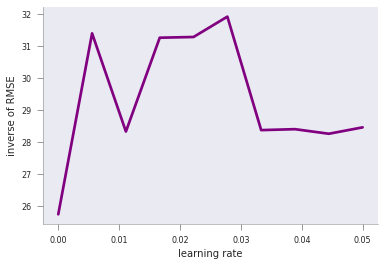

In [13]:
nnsvm(plt.rcParams, -2)
x = np.atleast_2d(np.linspace(0, 0.05, 10)).T
plt.plot(x, f(x), color='purple', label='GT')
plt.xlabel("learning rate")
plt.ylabel("inverse of RMSE")
format_axes(plt.gca())
plt.savefig('MAB_gifs/GT.svg', bbox_inches="tight")
plt.show()


#### Active Learning Procedure

1. Choose the point of having the highest uncertainty
2. Add the point to train set
3. Train on the new train set
4. Go to 1 till convergence or budget elapsed

In [13]:
def gp_creator(x, y, val = 5):
    y.resize(x.shape[0], 1)
    ker = Matern52(x.shape[1], ARD=True, variance=1)
#     print (x, x.mean())
    mean_fn = Constant(x.shape[1], 1, value=val)
    gp = GPRegression(x, y, kernel=ker, noise_var=0,
                      mean_function = mean_fn)
    gp.optimize()
    return gp

In [17]:
train_X = np.atleast_2d([0.005]).T
train_y =np.array(f(train_X)).flatten()
gp = gp_creator(train_X, np.array(train_y))
# Stopping criteria is 10 iterations
x = np.atleast_2d(np.linspace(0, 0.05, 10)).T
nnsvm(plt.rcParams, 2)
for i in range(10):
    # Fit on current train set
    gp = gp_creator(train_X,np.array(train_y))
#     gp.optimize(?)
    # predict on current pool set
    y_pred, var = [t.flatten() for t in gp.predict(x)]
    sigma = np.sqrt(var).squeeze()
    
    plt.plot(x, y_pred, 'k', label=r'Predicted ($\mu$)')
    plt.plot(x, f(x), 'purple', label=r'Ground Truth ($f$)')
    plt.xlabel("learning rate")
    plt.ylabel("inverse of RMSE")
    plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, 
                     color='gray', alpha=alpha_plt, label=r'$\mu \pm \sigma$')
    plt.scatter(train_X[:-1], train_y[:-1], color='black', s=300, zorder=10, label='Training points')
    plt.scatter(train_X[-1], train_y[-1], color='red', s=300, zorder=10, label='Query Point')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(f"Iteration: {i}")
    format_axes(plt.gca())
    
    dirName = 'active-gp-img_1'
    os.makedirs(dirName, exist_ok=True)
    plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight", dpi=180)
    plt.close()
    
    # Choose the next point with highest sigma
    next_ix = np.argmax(sigma)
    next_x = x[next_ix]
    # Add new point with highest uncertainty to the pool set
    train_X = np.vstack([train_X, [x[next_ix]]])
    train_y = f(train_X)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  84992     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  33024     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  84992     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  33024     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1

In [15]:
gp

GP_regression.,value,constraints,priors
constmap.C,5.0,,
Mat52.variance,1.0,+ve,
Mat52.lengthscale,1.0,+ve,
Gaussian_noise.variance,5.562684646268137e-309,+ve,


 Earlier in the active learning problem, our motivation for searching at different learning rate was to predict the distribution of the RMSE with different learning rate in the one-dimensional line. We, therefore, had chosen the next learninig rate to try where we had maximum uncertainty about our estimate.

In the following attempt, we are instead interested to know the learning rate at which we reach the minimum RMSE. For getting the location of minimum RMSE, we might want to find the learning rate where predicted mean is the highest (exploit). But unfortunately our mean is not always accurate, so we need to correct our mean (reduce variance / explore) too. Multi-Arm Bandit looks at both exploitation and exploration, whereas in the case of Active Learning Problem, we only cared about exploration.

#### Acquisition Functions

Now, to take into account the combination of exploration and exploitation, we try to use a function which combines the two sides. These utility functions that take into account both exploration and exploitation in multi-arm bandit problem are called acquisition functions.

In [29]:
val = 5

In [16]:
class ACQ:
    def acq_fn(self, *args, **kwargs):
        raise NotImplemented
    def __str__(self):
        return self.__class__.__name__
    def __call__(self, *args, **kwargs):
        return self.acq_fn(*args, **kwargs)

class ACQ1(ACQ):
    def acq_fn(self, gp, x, lam = 0.4, **kwrags):
        """
        gp: sklearn.GPRegresssor
        lam: float, where the objective is: \mu(x) + \lambda \sigma(x)
        """
        y_pred, var = [t.flatten() for t in gp.predict(x)]
        sigma = np.sqrt(var).squeeze()
        
        return y_pred + lam*sigma


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  84992     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  33024     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1

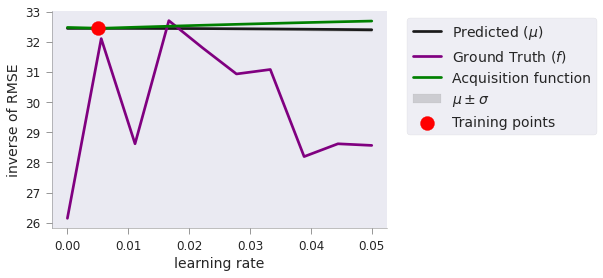

In [35]:
acq_obj = ACQ1()

train_X = np.atleast_2d([0.005]).T
train_y = f(train_X)
gp = gp_creator(train_X, np.array(train_y))
y_pred, var = [t.flatten() for t in gp.predict(x)]
sigma = np.sqrt(var).squeeze()

plt.plot(x, y_pred, 'k', label=r'Predicted ($\mu$)')
plt.plot(x, f(x), 'purple', label=r'Ground Truth ($f$)')
plt.xlabel("learning rate")
plt.ylabel("inverse of RMSE")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, 
                 color='gray', alpha=alpha_plt, label=r'$\mu \pm \sigma$')
plt.scatter(train_X, train_y, color='red', s=200, zorder=10, label='Training points')
plt.plot(x, acq_obj(gp, x, 5), label='Acquisition function', color='green')
format_axes(plt.gca())
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig(f"MAB_gifs/acq_fn.svg", bbox_inches="tight")

Here, we can see that mean near the location of the just added point (red point) is high. But as we go far from the red point, we see that our uncertainty increases to a maximum. As we discussed in multi-arm bandit problem, we like to have some combination of exploration and exploitation. The most basic way to do so is by linearly combining the two values.

### ACQ1

This combined value that takes into account exploration and exploitation is referred to as the acquisition value, returned by acquisition function. We see at around the location `x = 0.05` we get the maximum value for the acquisition (green curve). Thus we next select this location to drill.

The intuition of using the acquisition function `mean + lam * uncertainty` is that we are interested in finding the global mean, so taking into account the estimated mean would be a good idea. Additionally, we would like to explore too (using `lam`); else we might be stuck in a local minimum if don't explore too much (see below).



In [17]:
def rargmax(b):
    """Randomly tie breaking argmax"""
    return np.random.choice(np.flatnonzero(b == b.max()))
#train_y=np.array(train_y)
def plot_acquisition(
        train_X, train_y,
        acq_class, val,  acq_params={},
        ylim0=None, xlim0=None,
        ylim1=None, xlim1=None,
        y1scale='linear', it = 10,
        seed = 0
    ):
    """acq_params would contain the parameters for our acq_fn"""
    np.random.seed(seed)
    # for storing the max till it iters
    max_till_now = []
    
    # Stopping criteria is 10 iterations
    for i in range(it):
        fig, ax = plt.subplots(nrows=2, sharex=True)
        ax[1].set_yscale(y1scale)
        
        # limits
        #ax[0].set_ylim(ylim0) if ylim0 is not None else ax[0].set_ylim(min(f(x)-.5), max(f(x))+.5)
        #ax[0].set_xlim(xlim0) if xlim0 is not None else ax[0].set_xlim(min(x)-.5, max(x)+.5)
        #ax[1].set_ylim(ylim1) if ylim1 is not None else None
        #ax[1].set_xlim(xlim1) if xlim1 is not None else ax[1].set_xlim(min(x)-.5, max(x)+.5)
        
        # fitting
        gp = gp_creator(train_X, np.array(train_y), val)
        
        # plot Acquisition
        acq_obj = acq_class()
        acquisition = acq_obj(gp, x, t=i+1, 
                              **acq_params, 
                              mu=max(train_y))
        ax[1].plot(x, acquisition, label='Acquisition function', color='green')
        
        # predict on current pool set
        y_pred, var = [t.flatten() for t in gp.predict(x)]
        sigma = np.sqrt(var).squeeze()
        
        ax[0].plot(x, y_pred, 'k', label=r'Predicted ($\mu$)')
        ax[0].plot(x, f(x), 'purple', label=r'Ground Truth ($f$)')
        ax[0].set_xlabel("learning rate")
        ax[0].set_ylabel("inverse of RMSE")
        ax[0].fill_between(x.flatten(), y_pred+sigma,
                           y_pred-sigma, color='gray',
                           alpha=alpha_plt, label=r'$\mu \pm \sigma$')
        ax[0].scatter(train_X, train_y, color='black', s=100,
                      zorder=10, label='Training Points')
        ax[0].legend(bbox_to_anchor=(1.04,1), loc="upper left")
        if str(acq_obj) == "PI":
            ax[1].set_ylabel(r'$\alpha_{PI}$')
        elif str(acq_obj) == "EI":
            ax[1].set_ylabel(r'$\alpha_{EI}$')
        elif str(acq_obj) == "GP_UCB":
            ax[1].set_ylabel(r'$\alpha_{GP-UCB}$')
        elif str(acq_obj) == "ACQ1":
            ax[1].set_ylabel(r'$\alpha_{UCB}$')
        elif str(acq_obj) == "Rand":
            ax[1].set_ylabel(r'$\alpha_{Random}$')
        elif str(acq_obj) == "EI_PI":
            ax[1].set_ylabel(r'$\alpha_{EI-PI}$')
        elif str(acq_obj) == "Thompson":
            ax[1].set_ylabel(r'$\alpha_{Thompson}$')
        else:
            raise ValueError
          
        if len(acq_params.keys()) == 0:
            ax[0].set_title(f"Iteration: {i}")
        elif 'eps' in acq_params.keys():
            ax[0].set_title(f"Iteration: {i} \n" + r"$\epsilon$ = " + f"{acq_params['eps']}")
            
        elif 'lam' in acq_params.keys():
            ax[0].set_title(f"Iteration: {i} \n" + r"$\lambda$ = " + f"{acq_params['lam']}")
        
        elif 'v' in acq_params.keys():
            ax[0].set_title(f"Iteration: {i} \n" + \
                            r"$v$ = " + str(acq_params['v']) + '\n' \
                            r"$\delta$ = " + str(acq_params['delta']))

            
        
        # Choose the next point with highest sigma
        max_mu = np.max(train_y).item()
        max_till_now.append(max_mu)
        next_ix = rargmax(acquisition)
        next_x = x[next_ix]

        # Add new point with highest uncertainty to the pool set
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)

        # Add new point with highest uncertainty to the pool set
        ax[1].scatter(x[next_ix], acquisition[next_ix], marker='+',s=50,
                      c='blue', zorder=10, label='Maxima')
        ax[1].axvline(x = x[next_ix], color='black', lw=0.6, zorder=7, alpha=1)
        ax[1].axhline(y = acquisition[next_ix], color='black', lw=0.6, zorder=7, alpha=1)
        ax[0].scatter(x[next_ix], f(x)[next_ix], color='red',
                      s=200, zorder=1, label='Query Point')
        ax[0].legend(bbox_to_anchor=(1.1,1), loc="upper left")
        ax[1].legend(bbox_to_anchor=(1.1,0.5), loc="upper left")
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)
        format_axes(ax[0])
        format_axes(ax[1])

        acq_params_str = '-'.join(list(map(str, acq_params.values())))
        dirName = './MAB_pngs/'+str(acq_obj)+'_new'+'/'+acq_params_str
        os.makedirs(dirName, exist_ok=True)
        plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight", dpi=180)
        plt.close()
    return dirName, max_till_now

In [24]:
train_X = np.atleast_2d([0.005]).T
train_y = f(train_X)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  84992     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  33024     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________

In [18]:
nnsvm(plt.rcParams, 2)

In [37]:
acq_params = {'lam': 3}

dirName, mtn_acq = plot_acquisition(
    train_X, np.array(train_y),
    ACQ1,  val, acq_params
    #ylim1=(1, 14)
)

# !convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-{acq_params['lam']}.gif

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  84992     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  33024     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  84992     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  33024     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1

In [1]:
def max_til(mtn):
    mtn_new=[]
    for i in range(len(mtn)):
        mtn_new.append(max(mtn[:i+1]))
    return mtn_new

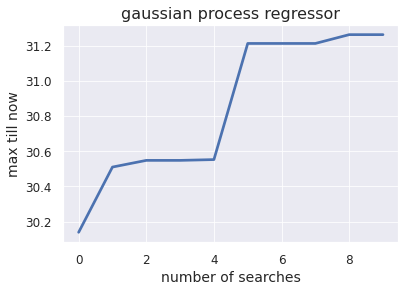

In [33]:
plt.plot(max_til(mtn_acq))
plt.xlabel("number of searches")
plt.ylabel("max till now")
plt.title("gaussian process regressor")
plt.show()



### Probability of Improvement (PI)
As before, we want to balance or trade-off between exploration and exploitation. The idea behind the algorithm is fairly simple - choose the next point as the one which has the highest probability of improvement over the current max ($\mu^+$).


Let's understand this concept via two cases:

1. We have two points of similar means (of function values (RMSE in our case)). We now want to choose one of these to obtain the labels or values. We will choose the one with higher variance. This basically says that given same exploitability, we choose the one with higher exploration value.
2. We have two points having same variance. We would now choose the point with the higher mean. This basically says that given same explorability, we will choose the one with higher exploitation value.


1. Let $\mu^+$ be the current highest value of the function
2. Let $\epsilon$ be close to zero
3. Choose $x^* = arg\,max(P(f(x)) > (\mu^+ +\epsilon))$

This can be given as: $x^* = _{arg\,max_{x}} \Phi(\frac{\mu(x) - \mu^+ - \epsilon}{\sigma(x)})$ where
$\Phi(.)$ indicates the CDF.

In [19]:

class PI(ACQ):
    def acq_fn(
        self, gp, x, mu=5., eps=0.01, **kwargs):
        """
        gp: sklearn.GPRegresssor
        """
        y_pred, var = [t.flatten() for t in gp.predict(x)]
        sigma = np.sqrt(var).squeeze()
        
        cdf = ndtr((y_pred - mu - eps)/sigma)   #Returns the area under the standard Gaussian probability density function,
        #integrated from minus infinity to x
        return cdf

In [50]:
train_X = np.atleast_2d([0.005]).T
train_y = np.array(f(train_X)).ravel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  84992     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  33024     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1

In [22]:
x = np.atleast_2d(np.linspace(0, 0.05, 10)).T

In [ ]:
eps = 0.075
acq_params = {
    'eps': eps
}

dirName, mtn_pi = plot_acquisition(
    train_X, train_y,
    PI, val,
    acq_params = acq_params
   # ylim1=((-.05, 1.05)),
)

# gify
# !convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-pi-eps{eps}.gif

![](MAB_gifs/mab-gp-pi-eps0.01.gif)

Looking at the graph above we can see that we are not effectively exploring at value `eps = 0.01` for the Probability of Improvement acquisition function. We are stuck.

In [23]:
val=5
eps = 0.3
acq_params = {
    'eps': eps
}

dirName, mtn_pi = plot_acquisition(
    train_X, train_y,
    PI, val,
    acq_params = acq_params
    #ylim1=((-.05, 1)),
    #y1scale='log'
)

# gify
# !convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-pi-eps{eps}.gif

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  84992     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  33024     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  84992     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  33024     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1

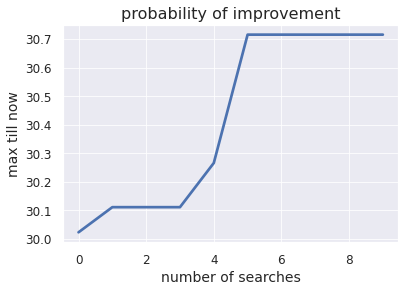

In [34]:
plt.plot(max_til(mtn_pi))
plt.xlabel("number of searches")
plt.ylabel("max till now")
plt.title("probability of improvement")
plt.show()

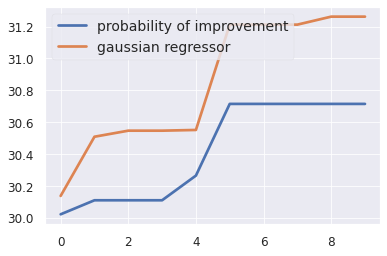

In [36]:
plt.plot(max_til(mtn_pi),label="probability of improvement")
plt.plot(max_til(mtn_acq),label="gaussian regressor")
plt.legend()




----

### Expected Improvement (EI)

Probability of improvement only looked at `how likely` is an improvement, but, shouldn't we be looking into `how much` we can improve. The next criterion called Expected Improvement (EI). It looks into both :)


In [37]:
class EI(ACQ):
    def acq_fn(self, gp, x, mu=5., eps=0.01, **kwargs):
        """
        gp: sklearn.GPRegresssor
        mu: max value of y among the selected train_pts
        """
        y_pred, var = [t.flatten() for t in gp.predict(x)]
        sigma = np.sqrt(var).squeeze()
        z = (y_pred - mu - eps)/sigma
        return (y_pred - mu - eps)*ndtr(z) + sigma*norm.pdf(z)

In [42]:
eps = 1.5
acq_params = {
    'eps': eps
}

dirName, mtn_ei = plot_acquisition(
    train_X, train_y,
    EI, val,
    acq_params=acq_params,
    ylim1=((-0.001, .3))
)

# gify!
# !convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei-eps{eps}.gif

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  84992     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  33024     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1

Text(0.5, 1.0, 'expected improvement')

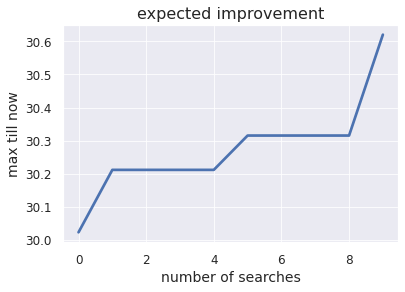

In [46]:
plt.plot(max_til(mtn_ei))
plt.xlabel("number of searches")
plt.ylabel("max till now")
plt.title("expected improvement")

---

### Thompson Sampling
One more acquisition function that is quite common is Thompson Sampling. It has a low overhead of setting up.

The idea is to sample functions within upper and lower probabilistic bounds of a regressor; one can then optimize on these functions and chose the next query point to be the $\boldsymbol{x} = argmax({sampled_f})$. 

Thompson Sampling is general enough to be useful even when we have Bernoulli (the domain of x is spatially independent) distributions modeling the function $F$, instead of Gaussian Process.

In [47]:
class Thompson(ACQ):
    def acq_fn(self, gp, x, mu=5., **kwargs):
        """
        gp: sklearn.GPRegresssor
        mu: max value of y among the selected train_pts
        x: domain in which we are optimizing
        """
        sampled_y = gp.posterior_samples_f(x, size=1)
#         print(sampled_y.shape)
        return sampled_y.flatten()

In [48]:
dirName, mtn_th = plot_acquisition(
    train_X, train_y,
    Thompson, val, ylim1=((0, 8.5)),
)

# gify!
# !convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-thomp.gif

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  84992     
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49408     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  33024     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8320      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1

Text(0.5, 1.0, 'Thompson')

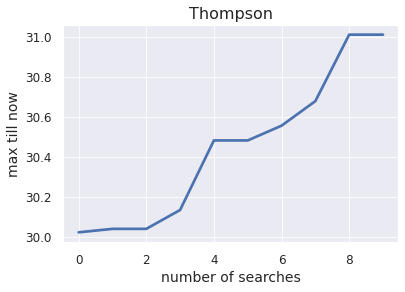

In [50]:
plt.plot(max_til(mtn_th))
plt.xlabel("number of searches")
plt.ylabel("max till now")
plt.title("Thompson")

### Comparison

Below we have a graph showing a comparison between the methods discussed above.

In [52]:
nnsvm(plt.rcParams, 4)

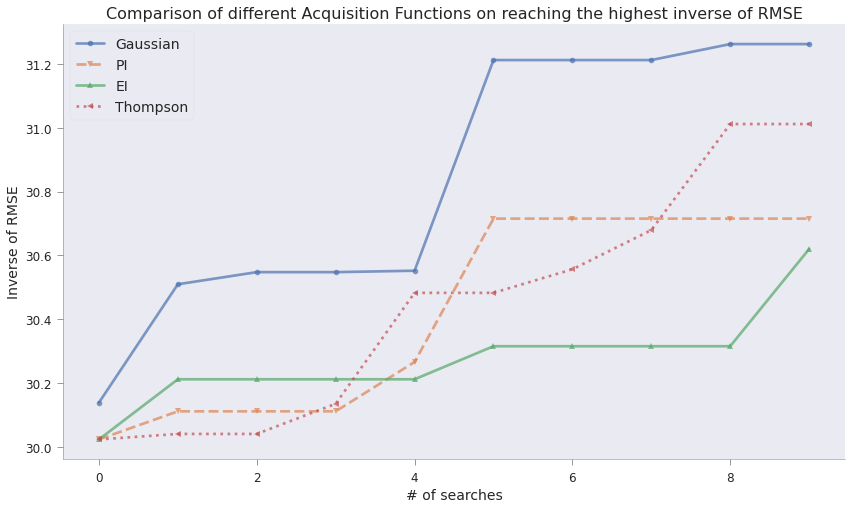

In [55]:
mtns = [ mtn_acq, mtn_pi, mtn_ei, mtn_th]
names = [ 'Gaussian', 'PI', 'EI', 'Thompson']
markers = ['o-', 'v--', '^-', '<:']

xx = range(len(mtns[0]))
plt.figure(figsize=(14, 8))
for n, m, mm in zip(names, mtns, markers):
    plt.plot(xx, max_til(m), mm, label=n, alpha=0.7, lw=2.7)

plt.legend()
plt.xlabel('# of searches')
plt.ylabel('Inverse of RMSE')
plt.title('Comparison of different Acquisition Functions on reaching the highest inverse of RMSE')
format_axes(plt.gca())
plt.savefig("MAB_gifs/comp.svg", bbox_inches="tight")
plt.show()